In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
from scipy.signal import savgol_filter
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import matplotlib.ticker as ticker


In [2]:
SPAN = 100
WINDOW_LENGTH = 25
POLY_ORDER = 8

def calculateAverageEngagementsPerDay(dataframe):
    dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
    dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
    engagements_per_day = dataframe.groupby(['created_at_day']).agg({'engagement_rate':'sum'}).reset_index()
    tweets_per_day = (dataframe.groupby(['created_at_day'])['tweet'].count()).to_frame('tweets_per_day')
    
    average_engagements_per_day = tweets_per_day.merge(engagements_per_day, how='inner', on='created_at_day')
    average_engagements_per_day['average_engagement_per_day'] = np.round((average_engagements_per_day['engagement_rate']/ (4 * average_engagements_per_day['tweets_per_day'])), 2)
    
    return average_engagements_per_day

In [3]:
INFLUENCERS_PATH = '../../data/con_sentimientos_estallido/influencers/'
MEDIA_PATH = '../../data/con_sentimientos_estallido/prensa_escrita/'
TELEVISION_PATH = '../../data/con_sentimientos_estallido/television/'

user_info_df = pd.read_csv('../../data/user_info_updated.csv')


In [4]:
influencers_avg_engagements_per_day_df = pd.DataFrame()

# todos los influencers
imprimir = []
imprimir.append("****INFLUENCERS****")
for file in glob.glob(INFLUENCERS_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-18T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    # Combine all topics
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [5]:
prensa_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****PRENSA Y RADIO****")
for file in glob.glob(MEDIA_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    if username == "Tele13_Radio":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-18T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\1990533384.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: Settin

In [6]:
television_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****TELEVISION****")
for file in glob.glob(TELEVISION_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    if username == "CNNChile":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-17T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_26008\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [7]:
for texto in imprimir:
    print(texto)
    print("*"*50)

****INFLUENCERS****
**************************************************
andres20ad pre:2.891 post:6.715
**************************************************
Chileokulto pre:4.135 post:10.767
**************************************************
csantander23 pre:0.215 post:0.458
**************************************************
El_Ciudadano pre:1.18 post:3.042
**************************************************
FelipeParadaM pre:13.364 post:17.289
**************************************************
GAMBA_CL pre:3.24 post:8.926
**************************************************
hernan_sr pre:2.611 post:2.65
**************************************************
JoviNomas pre:4.903 post:9.755
**************************************************
PiensaPrensa pre:2.401 post:7.871
**************************************************
vagoilustrado pre:0.685 post:2.605
**************************************************
****PRENSA Y RADIO****
**************************************************
adnradiochile pr

In [8]:
influencers_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(influencers_avg_engagements_per_day_df["created_at_day"])
influencers_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2019-01-01,16,1983,30.98,30.980000,andres20ad,0.021959,-1.684874,30.599407,0.671943
1,2019-01-02,12,3364,70.08,31.754257,andres20ad,0.021959,-1.671917,33.297584,0.731193
2,2019-01-03,5,5033,251.65,36.108629,andres20ad,0.021959,-1.599047,34.459189,0.756701
3,2019-01-04,16,1924,30.06,35.988854,andres20ad,0.021959,-1.601051,35.551755,0.780693
4,2019-01-05,9,1780,49.44,36.255213,andres20ad,0.021959,-1.596594,37.136461,0.815492
...,...,...,...,...,...,...,...,...,...,...
6723,2020-12-27,2,2354,294.25,226.823143,vagoilustrado,0.011090,-0.365872,225.801540,2.504214
6724,2020-12-28,5,2028,101.40,224.339516,vagoilustrado,0.011090,-0.478608,227.978613,2.528359
6725,2020-12-29,5,12679,633.95,232.450615,vagoilustrado,0.011090,-0.110431,230.436908,2.555622
6726,2020-12-30,13,12319,236.90,232.538721,vagoilustrado,0.011090,-0.106432,232.628499,2.579927


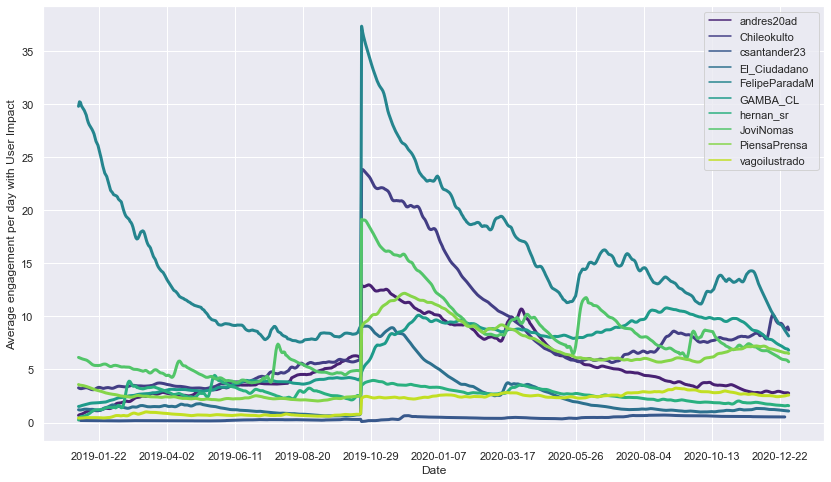

In [9]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=influencers_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('influencers_social_engagement.pdf')
plt.show()


In [10]:
prensa_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(prensa_avg_engagements_per_day_df["created_at_day"])
prensa_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2019-01-01,40,1279,7.99,7.990000,adnradiochile,0.501193,-1.049320,7.961353,3.990172
1,2019-01-02,112,1652,3.69,7.904851,adnradiochile,0.501193,-1.181479,7.970640,3.994826
2,2019-01-03,146,2825,4.84,7.844161,adnradiochile,0.501193,-1.275676,7.856382,3.937561
3,2019-01-04,120,3037,6.33,7.814178,adnradiochile,0.501193,-1.322213,7.755855,3.887178
4,2019-01-05,61,1248,5.11,7.760630,adnradiochile,0.501193,-1.405325,7.707671,3.863028
...,...,...,...,...,...,...,...,...,...,...
6308,2020-12-27,85,3482,10.24,13.361041,thecliniccl,0.286438,-1.014268,13.293361,3.807723
6309,2020-12-28,212,4726,5.57,13.206763,thecliniccl,0.286438,-1.022859,13.174447,3.773661
6310,2020-12-29,211,5388,6.38,13.071580,thecliniccl,0.286438,-1.030388,13.082611,3.747356
6311,2020-12-30,186,5108,6.87,12.948776,thecliniccl,0.286438,-1.037227,12.990237,3.720897


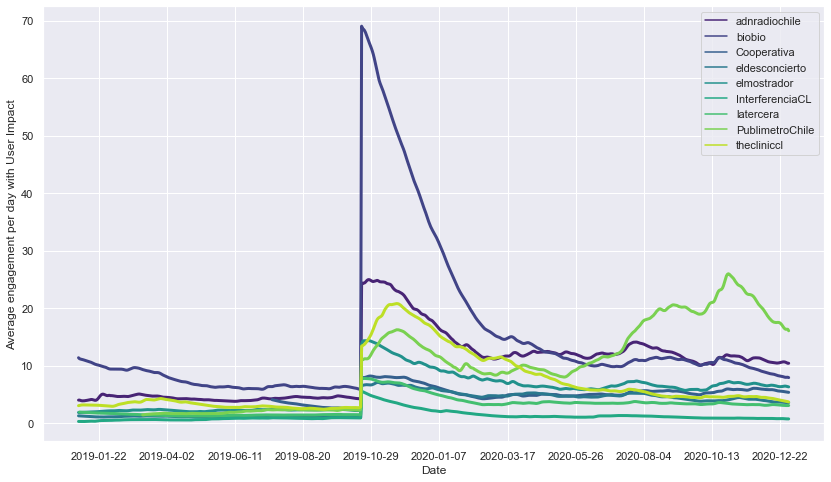

In [11]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=prensa_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('press_social_engagement.pdf')
plt.show()


In [12]:
television_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(television_avg_engagements_per_day_df["created_at_day"])
#television_avg_engagements_per_day_df.to_excel("television.xlsx")

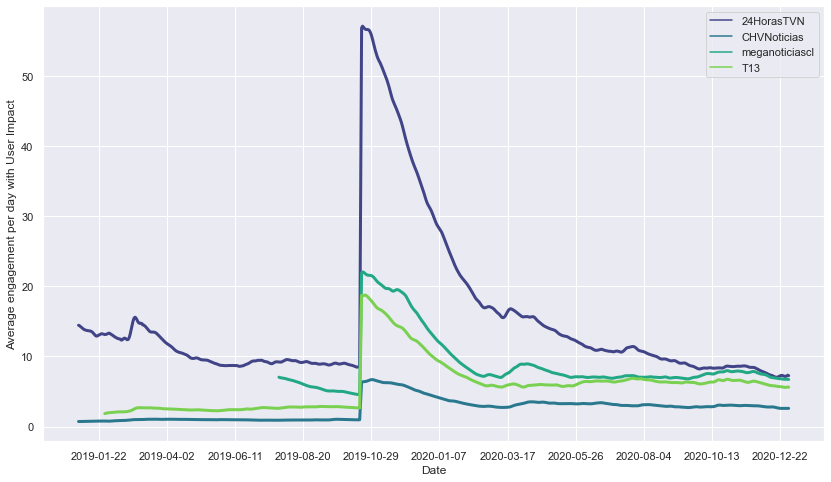

In [13]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=television_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('television_social_engagement.pdf')
plt.show()


# Sin normalizar

In [35]:
user_info_df

,created_at,name,username,followers_count,following_count,tweet_count,listed_count,description,location,verified,impact,user_impact_scaled
0,2015-09-01 23:37:11+00:00,PIENSAPRENSA 327 mil Seguidores,PiensaPrensa,327907,39521,72612,767,"Chilenos, autogestionados, Independientes, com...","Santiago, Chile ±56987524113",True,8.642746,0.010239
1,2009-02-28 23:47:11+00:00,Felipe Parada 🔻,FelipeParadaM,79830,3840,197773,144,"Hijo de obrero. Rebeldía, Resistencia y Amor |...","Providencia, Chile",False,1.134771,0.001430
2,2010-07-19 10:52:44+00:00,Vagabundo ilustrado,vagoilustrado,125296,271,15847,168,"Otoñista, Yournalista, analista y maestro tier...",@vagoilustrado@seda.social,False,0.246825,0.000388
3,2013-06-01 03:31:15+00:00,Carlos Santander,csantander23,2431,256,7338,3,San Antonio — Melipilla,NaN,False,0.001751,0.000100
4,2016-08-09 00:12:48+00:00,Andrés 💪🕊 🍁✊ #YoAnulo,andres20ad,41891,13171,46890,57,"Uno de muchos, que luchan por mejorar este mun...",NaN,False,0.461256,0.000639
5,2012-11-24 01:51:19+00:00,Chileokulto,Chileokulto,236743,58970,248120,335,@Chileokulto El primer Panfleto virtual de Chi...,En el Chile que nadie ve.,False,4.534446,0.005419
6,2009-04-24 18:06:25+00:00,Hernán,hernan_sr,30977,11302,134503,90,tweets con ají incluido. 🌶️,NaN,True,0.281730,0.000429
7,2018-06-13 14:18:58+00:00,HonorYGloria ❤🔥,JoviNomas,34594,1694,113660,37,"Bajo el cielo de Moscú.\nMilitante del dolor, ...",Constelación de Orión ⭐,False,3.591195,0.004312
8,2008-04-19 17:43:02+00:00,El Ciudadano,El_Ciudadano,581822,71419,240898,1785,https://t.co/hF7jqSE6Tk medio de comunicación ...,Santiago de Chile,True,11.707710,0.013836
9,2010-07-19 00:03:03+00:00,GAMBA,GAMBA_CL,213205,137,81389,384,El medio más carismático de la historia. Centr...,NaN,False,3.441916,0.004137


In [36]:
influencers_avg_engagements_per_day_df = pd.DataFrame()

# todos los influencers
imprimir = []
imprimir.append("****INFLUENCERS****")
for file in glob.glob(INFLUENCERS_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['impact'].unique()[0]
    
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-18T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    # Combine all topics
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

In [38]:
prensa_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****PRENSA Y RADIO****")
for file in glob.glob(MEDIA_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['impact'].unique()[0]
    
    if username == "Tele13_Radio":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-18T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\405053817.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

In [39]:
television_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****TELEVISION****")
for file in glob.glob(TELEVISION_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['impact'].unique()[0]
    if username == "CNNChile":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2019-10-17T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2019-10-18T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\70351506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_15212\3124343641.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)


In [40]:
influencers_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(influencers_avg_engagements_per_day_df["created_at_day"])
influencers_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2019-01-01,16,1983,30.98,30.980000,andres20ad,0.461256,-1.684874,32.152852,14.830686
1,2019-01-02,12,3364,70.08,31.754257,andres20ad,0.461256,-1.671917,31.642938,14.595485
2,2019-01-03,5,5033,251.65,36.108629,andres20ad,0.461256,-1.599047,32.953977,15.200210
3,2019-01-04,16,1924,30.06,35.988854,andres20ad,0.461256,-1.601051,35.223214,16.246908
4,2019-01-05,9,1780,49.44,36.255213,andres20ad,0.461256,-1.596594,37.853453,17.460121
...,...,...,...,...,...,...,...,...,...,...
6723,2020-12-27,2,2354,294.25,226.823143,vagoilustrado,0.246825,-0.365872,225.613799,55.687013
6724,2020-12-28,5,2028,101.40,224.339516,vagoilustrado,0.246825,-0.478608,228.183707,56.321329
6725,2020-12-29,5,12679,633.95,232.450615,vagoilustrado,0.246825,-0.110431,230.709913,56.944859
6726,2020-12-30,13,12319,236.90,232.538721,vagoilustrado,0.246825,-0.106432,232.586315,57.408001


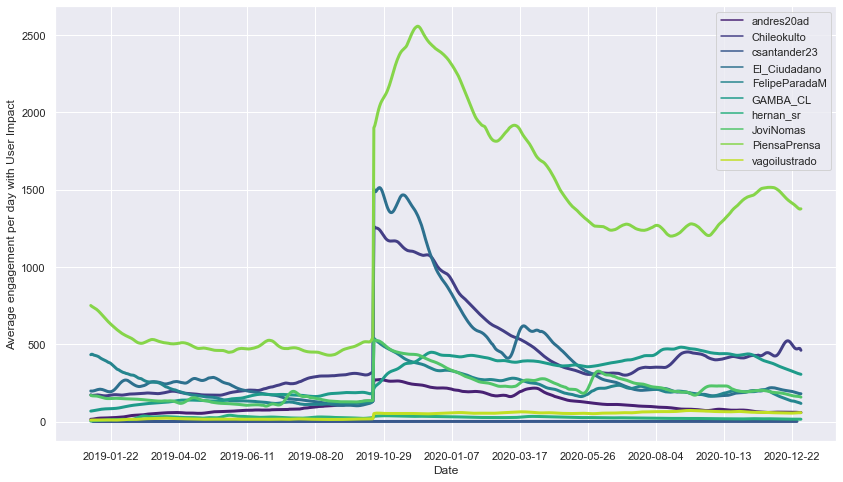

In [41]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=influencers_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.show()
#AGREGAR ESTE Y HACER UNO SIMILAR CON NEGATIVIDAD EN EL TIEMPO

In [42]:
prensa_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(prensa_avg_engagements_per_day_df["created_at_day"])
prensa_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2019-01-01,40,1279,7.99,7.990000,adnradiochile,208.332095,-1.049320,8.164223,1700.869662
1,2019-01-02,112,1652,3.69,7.904851,adnradiochile,208.332095,-1.181479,7.780675,1620.964375
2,2019-01-03,146,2825,4.84,7.844161,adnradiochile,208.332095,-1.275676,7.657237,1595.248201
3,2019-01-04,120,3037,6.33,7.814178,adnradiochile,208.332095,-1.322213,7.674756,1598.898072
4,2019-01-05,61,1248,5.11,7.760630,adnradiochile,208.332095,-1.405325,7.752597,1615.114726
...,...,...,...,...,...,...,...,...,...,...
6309,2020-12-27,85,3482,10.24,13.361041,thecliniccl,129.153154,-1.014268,13.321286,1720.486070
6310,2020-12-28,212,4726,5.57,13.206763,thecliniccl,129.153154,-1.022859,13.216658,1706.973130
6311,2020-12-29,211,5388,6.38,13.071580,thecliniccl,129.153154,-1.030388,13.103375,1692.342174
6312,2020-12-30,186,5108,6.87,12.948776,thecliniccl,129.153154,-1.037227,12.967226,1674.758140


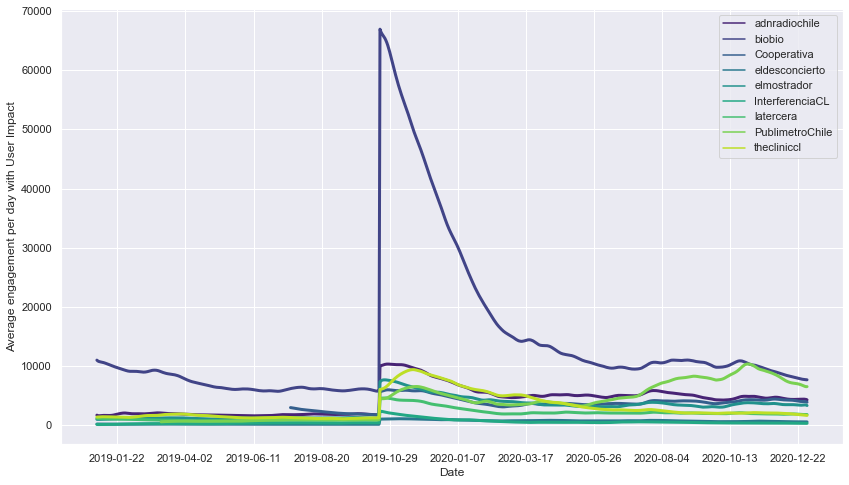

In [43]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=prensa_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.show()

In [44]:
television_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(television_avg_engagements_per_day_df["created_at_day"])


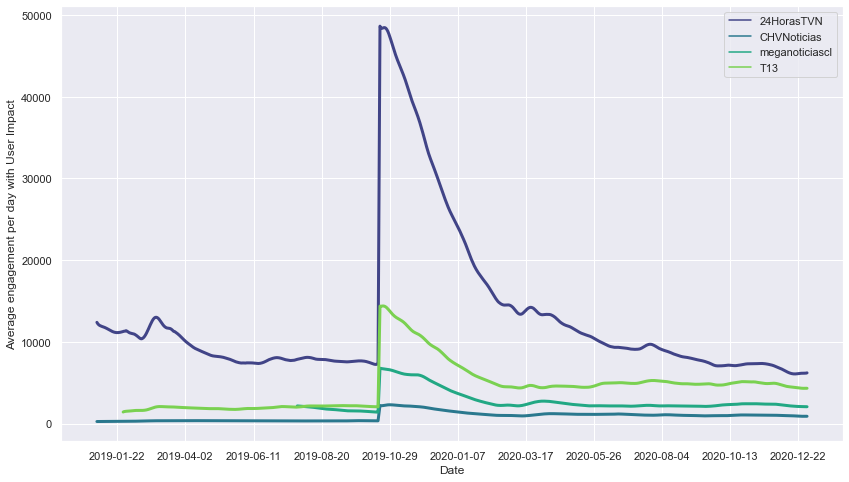

In [45]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=television_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.show()

# COVID


In [17]:
INFLUENCERS_PATH = '../../data/covid/con_sentimientos/influencers/'
MEDIA_PATH = '../../data/covid/con_sentimientos/prensa_escrita/'
TELEVISION_PATH = '../../data/covid/con_sentimientos/television/'

user_info_df = pd.read_csv('../../data/user_info_updated.csv')


In [18]:
influencers_avg_engagements_per_day_df = pd.DataFrame()

# todos los influencers
imprimir = []
imprimir.append("****INFLUENCERS****")
for file in glob.glob(INFLUENCERS_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2020-03-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2020-03-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    # Combine all topics
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [20]:
prensa_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****PRENSA Y RADIO****")
for file in glob.glob(MEDIA_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    if username == "Tele13_Radio":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2020-03-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2020-03-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\73031917.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\73031917.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [19]:
television_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****TELEVISION****")
for file in glob.glob(TELEVISION_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    if username == "CNNChile":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2020-03-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2020-03-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\3303722357.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)


In [35]:
for texto in imprimir:
    print(texto)
    print("*"*50)

****INFLUENCERS****
**************************************************
csantander23 pre:0.357 post:0.535
**************************************************
El_Ciudadano pre:1.301 post:1.511
**************************************************
FelipeParadaM pre:13.205 post:18.566
**************************************************
FrancoBassoSotz pre:0.162 post:0.207
**************************************************
Izkia pre:0.598 post:3.832
**************************************************
Pa__tty pre:1.687 post:3.756
**************************************************
PolarBearby pre:12.424 post:3.691
**************************************************
RockandRolec pre:0.753 post:0.312
**************************************************
UPLaRadio pre:0.272 post:0.57
**************************************************
Vitalicio7020 pre:5.182 post:2.363
**************************************************
****PRENSA Y RADIO****
**************************************************
adnradiochile 

In [21]:
influencers_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(influencers_avg_engagements_per_day_df["created_at_day"])
influencers_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2020-01-05,2,1940,242.50,242.500000,csantander23,0.001631,1.840263,243.003834,0.396221
1,2020-01-06,2,583,72.88,239.141188,csantander23,0.001631,1.575046,237.941613,0.387967
2,2020-01-09,2,1288,161.00,237.593838,csantander23,0.001631,1.452864,236.889873,0.386253
3,2020-01-10,1,97,24.25,233.369207,csantander23,0.001631,1.119281,236.315722,0.385316
4,2020-01-12,2,2555,319.38,235.072391,csantander23,0.001631,1.253767,234.937468,0.383069
...,...,...,...,...,...,...,...,...,...,...
3088,2020-11-26,19,2267,29.83,70.104777,Vitalicio7020,0.027844,-1.221178,70.797593,1.971271
3089,2020-11-27,19,6661,87.64,70.452010,Vitalicio7020,0.027844,-1.192441,70.777902,1.970722
3090,2020-11-28,24,3486,36.31,69.775930,Vitalicio7020,0.027844,-1.248393,69.910876,1.946581
3091,2020-11-29,49,10951,55.87,69.500565,Vitalicio7020,0.027844,-1.271181,68.928923,1.919240


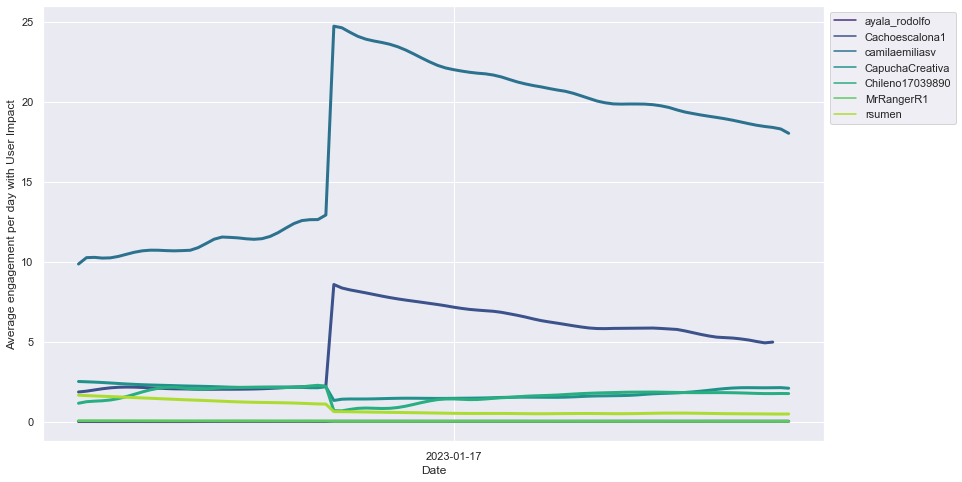

In [54]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=influencers_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('influencers_covid_engagement.pdf')
plt.show()


In [23]:
prensa_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(prensa_avg_engagements_per_day_df["created_at_day"])
prensa_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2020-01-01,46,4918,26.73,26.730000,adnradiochile,0.501193,2.110053,26.770829,13.417343
1,2020-01-02,102,3447,8.45,26.368020,adnradiochile,0.501193,1.928783,26.242244,13.152420
2,2020-01-03,101,3400,8.42,26.012613,adnradiochile,0.501193,1.750806,26.073891,13.068042
3,2020-01-04,48,3410,17.76,25.849195,adnradiochile,0.501193,1.668971,25.920410,12.991119
4,2020-01-05,31,1899,15.31,25.640498,adnradiochile,0.501193,1.564462,25.690352,12.875816
...,...,...,...,...,...,...,...,...,...,...
3008,2020-11-26,160,10076,15.74,16.088101,thecliniccl,0.286438,-0.782263,16.118808,4.617038
3009,2020-11-27,175,15922,22.75,16.220020,thecliniccl,0.286438,-0.771408,16.148458,4.625531
3010,2020-11-28,103,6655,16.15,16.218633,thecliniccl,0.286438,-0.771522,16.187051,4.636586
3011,2020-11-29,100,4005,10.01,16.095690,thecliniccl,0.286438,-0.781639,16.174188,4.632901


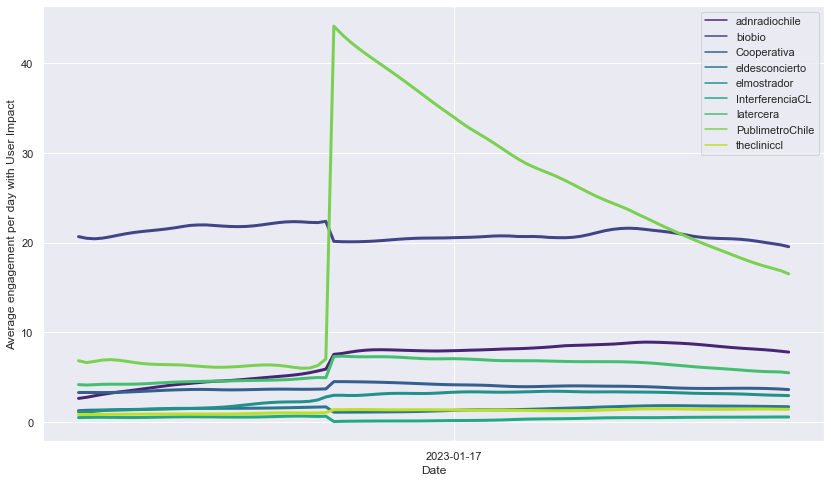

In [55]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=prensa_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('press_covid_engagement.pdf')
plt.show()


In [25]:
television_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(television_avg_engagements_per_day_df["created_at_day"])
#television_avg_engagements_per_day_df.to_excel("television.xlsx")

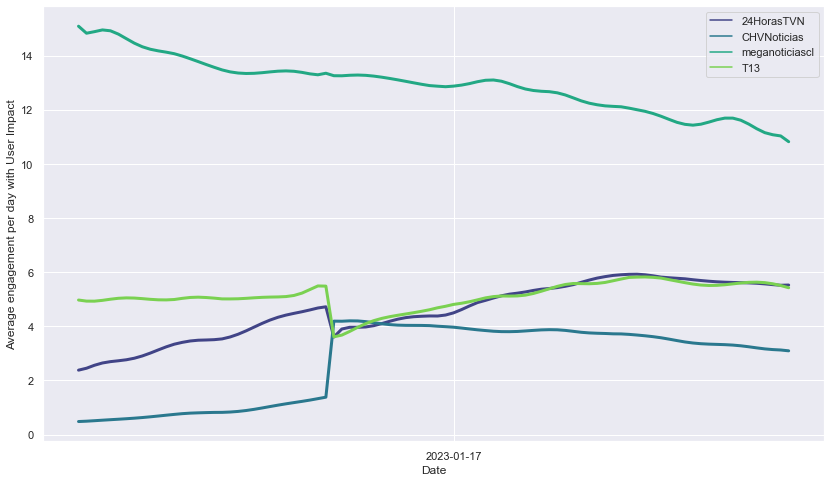

In [56]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=television_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('television_covid_engagement.pdf')
plt.show()


# INCENDIOS 2017

In [27]:
INFLUENCERS_PATH = '../../data/incendios_2017/con_sentimientos/influencers/'
MEDIA_PATH = '../../data/incendios_2017/con_sentimientos/prensa_escrita/'
TELEVISION_PATH = '../../data/incendios_2017/television/'

user_info_df = pd.read_csv('../../data/user_info_updated.csv')


In [28]:
influencers_avg_engagements_per_day_df = pd.DataFrame()

# todos los influencers
imprimir = []
imprimir.append("****INFLUENCERS****")
for file in glob.glob(INFLUENCERS_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2017-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2017-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    # Combine all topics
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\1395548222.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py

In [29]:
prensa_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****PRENSA Y RADIO****")
for file in glob.glob(MEDIA_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    if username == "Tele13_Radio":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2017-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2017-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\3481299753.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: Settin

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\3481299753.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)


In [30]:
television_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****TELEVISION****")
for file in glob.glob(TELEVISION_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    if username == "CNNChile" or username == "CHVNoticias":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2017-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2017-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [53]:
for texto in imprimir:
    print(texto)
    print("*"*50)

****INFLUENCERS****
**************************************************
ablanch4 pre:0.129 post:0.344
**************************************************
alegriagonzaa pre:0.52 post:0.702
**************************************************
bomberoschillan pre:0.027 post:0.079
**************************************************
CEBioBio pre:0.181 post:0.139
**************************************************
InfoNuble pre:0.019 post:0.031
**************************************************
INFORMADORCHILE pre:1.993 post:2.363
**************************************************
PiensaPrensa pre:1.243 post:0.707
**************************************************
reddeemergencia pre:1.543 post:2.291
**************************************************
S_Schwartzmann pre:0.47 post:0.654
**************************************************
****PRENSA Y RADIO****
**************************************************
adnradiochile pre:2.635 post:3.375
**************************************************
biobi

In [32]:
influencers_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(influencers_avg_engagements_per_day_df["created_at_day"])
influencers_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2016-12-01,47,392,2.09,2.090000,ablanch4,0.037434,-1.966821,2.042323,0.076453
1,2016-12-02,57,1066,4.68,2.141287,ablanch4,0.037434,-1.892019,2.305033,0.086287
2,2016-12-03,43,5156,29.98,2.692549,ablanch4,0.037434,-1.088007,2.540284,0.095094
3,2016-12-04,68,1032,3.79,2.714280,ablanch4,0.037434,-1.056311,2.706825,0.101328
4,2016-12-05,80,1937,6.05,2.780334,ablanch4,0.037434,-0.959972,2.813332,0.105315
...,...,...,...,...,...,...,...,...,...,...
548,2017-01-27,116,2718,5.86,2.876356,S_Schwartzmann,0.236743,0.675881,2.873777,0.680347
549,2017-01-28,87,2186,6.28,2.943754,S_Schwartzmann,0.236743,1.075342,2.977323,0.704861
550,2017-01-29,91,4092,11.24,3.108037,S_Schwartzmann,0.236743,2.049013,3.080793,0.729357
551,2017-01-30,88,2007,5.70,3.159363,S_Schwartzmann,0.236743,2.353214,3.168287,0.750070


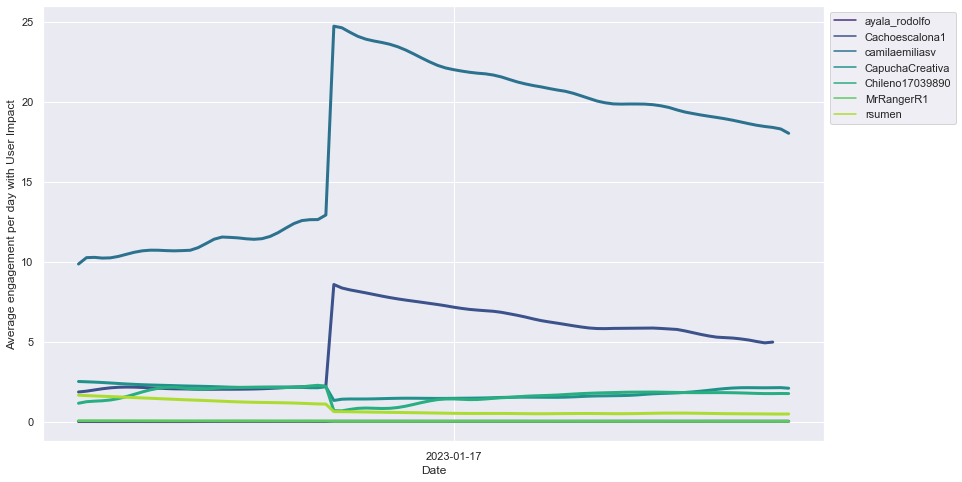

In [57]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=influencers_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('influencers_2017_engagement.pdf')
plt.show()


In [34]:
prensa_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(prensa_avg_engagements_per_day_df["created_at_day"])
prensa_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2016-12-01,160,3468,5.42,5.420000,adnradiochile,0.501193,0.993971,5.419783,2.716356
1,2016-12-02,133,2096,3.94,5.390693,adnradiochile,0.501193,0.815786,5.387369,2.700110
2,2016-12-03,79,1798,5.69,5.396620,adnradiochile,0.501193,0.851821,5.412011,2.712460
3,2016-12-04,92,2724,7.40,5.436291,adnradiochile,0.501193,1.093019,5.419739,2.716333
4,2016-12-05,144,2130,3.70,5.401909,adnradiochile,0.501193,0.883977,5.398544,2.705711
...,...,...,...,...,...,...,...,...,...,...
490,2017-01-27,63,3011,11.95,5.647626,thecliniccl,0.286438,1.640156,5.668827,1.623767
491,2017-01-28,48,2974,15.49,5.842524,thecliniccl,0.286438,2.030395,5.841645,1.673269
492,2017-01-29,47,1431,7.61,5.877524,thecliniccl,0.286438,2.100473,5.896898,1.689095
493,2017-01-30,56,1091,4.87,5.857573,thecliniccl,0.286438,2.060526,5.848688,1.675286


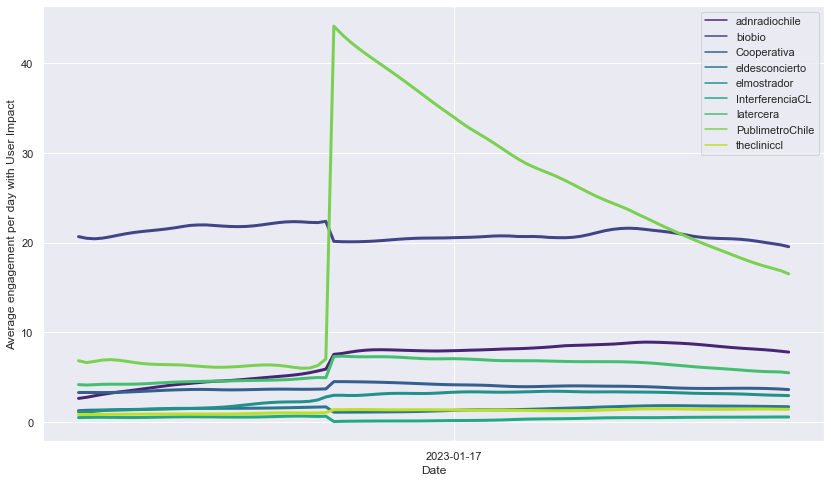

In [58]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=prensa_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('press_2017_engagement.pdf')
plt.show()


In [36]:
television_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(television_avg_engagements_per_day_df["created_at_day"])
#television_avg_engagements_per_day_df.to_excel("television.xlsx")

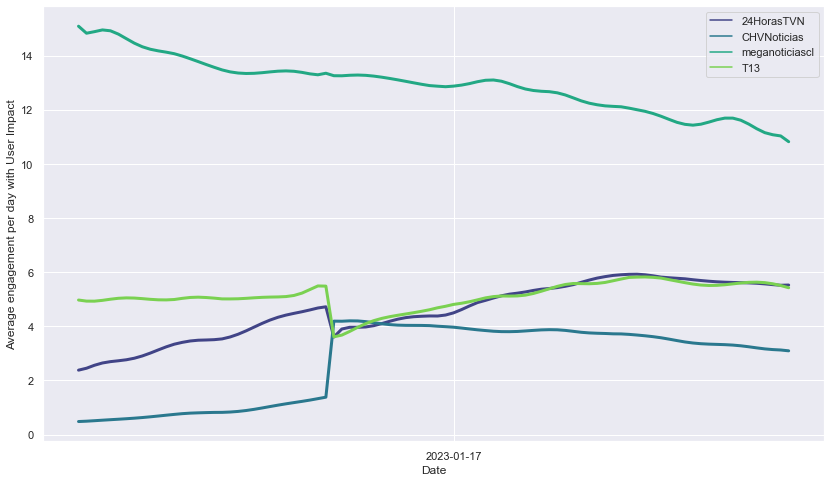

In [59]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=television_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('television_2017_engagement.pdf')
plt.show()


# INCENDIOS 2023

In [38]:
INFLUENCERS_PATH = '../../data/incendios_2023/con_sentimientos/influencers/'
MEDIA_PATH = '../../data/incendios_2023/con_sentimientos/prensa_escrita/'
TELEVISION_PATH = '../../data/incendios_2023/con_sentimientos/television/'

user_info_df = pd.read_csv('../../data/user_info_updated.csv')


In [39]:
influencers_avg_engagements_per_day_df = pd.DataFrame()

# todos los influencers
imprimir = []
imprimir.append("****INFLUENCERS****")
for file in glob.glob(INFLUENCERS_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    if username == 'JackoProu' or username == 'SpreenDMC':
        continue
    
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2023-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2023-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    # Combine all topics
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    influencers_avg_engagements_per_day_df = influencers_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [40]:
username

'SpreenDMC'

In [41]:
prensa_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****PRENSA Y RADIO****")
for file in glob.glob(MEDIA_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    
    if username == "Tele13_Radio":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2023-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2023-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\3948305851.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prensa_avg_engagements_per_day_df = prensa_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: Settin

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

In [42]:
television_avg_engagements_per_day_df = pd.DataFrame()

imprimir.append("****TELEVISION****")
for file in glob.glob(TELEVISION_PATH+'/*.csv'):
    user_df = pd.read_csv(file)
   
    username = user_df['username'].unique()[0]
    user_impact = user_info_df[user_info_df['username'] == username]['user_impact_scaled'].unique()[0]
    if username == "CNNChile":
        continue
    
    # Calculate average engagement per day & it's Exponential Moving Average
    pre_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] < '2023-01-01T00:00:00Z'])
    pre_user_avg_engagements_per_day['EMA']= pre_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    pre_user_avg_engagements_per_day['user'] = username  
    pre_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    pre_user_avg_engagements_per_day['zscore'] = stats.zscore(pre_user_avg_engagements_per_day['EMA'])
    #pre_user_avg_engagements_per_day = pre_user_avg_engagements_per_day[(pre_user_avg_engagements_per_day.zscore >= -3) & (pre_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    pre_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(pre_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    pre_user_avg_engagements_per_day['EMA*user_impact'] = pre_user_avg_engagements_per_day['EMA:Degree8'].mul(pre_user_avg_engagements_per_day['user_impact'])
    
    # Calculate average engagement per day & it's Exponential Moving Average
    post_user_avg_engagements_per_day = calculateAverageEngagementsPerDay(user_df[user_df['created_at'] > '2023-01-01T00:00:00Z'])
    post_user_avg_engagements_per_day['EMA']= post_user_avg_engagements_per_day.iloc[:,3].ewm(span=SPAN, adjust=False).mean()
    post_user_avg_engagements_per_day['user'] = username  
    post_user_avg_engagements_per_day['user_impact'] = user_impact
    
    #  Calculate z-score & Remove outliers
    post_user_avg_engagements_per_day['zscore'] = stats.zscore(post_user_avg_engagements_per_day['EMA'])
    #post_user_avg_engagements_per_day = post_user_avg_engagements_per_day[(post_user_avg_engagements_per_day.zscore >= -3) & (post_user_avg_engagements_per_day.zscore <= 3)]

    # Curve Smoothing
    post_user_avg_engagements_per_day['EMA:Degree8'] = savgol_filter(post_user_avg_engagements_per_day['EMA'], WINDOW_LENGTH, POLY_ORDER)
    
    # Add user-impact to EMA    
    post_user_avg_engagements_per_day['EMA*user_impact'] = post_user_avg_engagements_per_day['EMA:Degree8'].mul(post_user_avg_engagements_per_day['user_impact'])
    
    
    imprimir.append(str(username+' pre:' + str(round(pre_user_avg_engagements_per_day['EMA*user_impact'].mean(),3))+ ' post:'+ str(round(post_user_avg_engagements_per_day['EMA*user_impact'].mean(),3) )))
    user_avg_engagements_per_day = pd.concat([pre_user_avg_engagements_per_day, post_user_avg_engagements_per_day], ignore_index = True)
    
    television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['engagement_rate'] = dataframe['like_count'].astype(int) + dataframe['reply_count'].astype(int) + dataframe['retweet_count'].astype(int) + dataframe['quote_count'].astype(int)
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str

C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\794460127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_at_day'] = pd.to_datetime(dataframe['created_at'].str[:10])
C:\Users\Francisco Alessandri\AppData\Local\Temp\ipykernel_22084\2655412493.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  television_avg_engagements_per_day_df = television_avg_engagements_per_day_df.append(user_avg_engagements_per_day, ignore_index=True, sort=False)


In [43]:
for texto in imprimir:
    print(texto)
    print("*"*50)

****INFLUENCERS****
**************************************************
ayala_rodolfo pre:0.011 post:0.023
**************************************************
Cachoescalona1 pre:2.076 post:6.536
**************************************************
camilaemiliasv pre:11.183 post:20.928
**************************************************
CapuchaCreativa pre:2.249 post:1.653
**************************************************
Chileno17039890 pre:1.933 post:1.513
**************************************************
MrRangerR1 pre:0.046 post:0.024
**************************************************
rsumen pre:1.347 post:0.525
**************************************************
****PRENSA Y RADIO****
**************************************************
adnradiochile pre:4.312 post:8.277
**************************************************
biobio pre:21.622 post:20.62
**************************************************
Cooperativa pre:3.536 post:4.034
**************************************************
eldes

In [44]:
influencers_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(influencers_avg_engagements_per_day_df["created_at_day"])
influencers_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2022-12-01,20,1666,20.82,20.820000,ayala_rodolfo,0.000390,-0.918384,20.451936,0.007975
1,2022-12-02,9,211,5.86,20.523762,ayala_rodolfo,0.000390,-0.961745,21.567640,0.008410
2,2022-12-03,14,2507,44.77,21.003886,ayala_rodolfo,0.000390,-0.891468,20.635799,0.008047
3,2022-12-04,6,38,1.58,20.619254,ayala_rodolfo,0.000390,-0.947767,19.925492,0.007770
4,2022-12-05,13,199,3.83,20.286794,ayala_rodolfo,0.000390,-0.996430,19.981816,0.007792
...,...,...,...,...,...,...,...,...,...,...
608,2023-02-24,21,727,8.65,8.394821,rsumen,0.057784,-1.013276,8.406683,0.485772
609,2023-02-25,11,292,6.64,8.360072,rsumen,0.057784,-1.064509,8.342538,0.482065
610,2023-02-26,5,85,4.25,8.278684,rsumen,0.057784,-1.184503,8.265771,0.477629
611,2023-02-27,9,179,4.97,8.213166,rsumen,0.057784,-1.281100,8.212315,0.474540


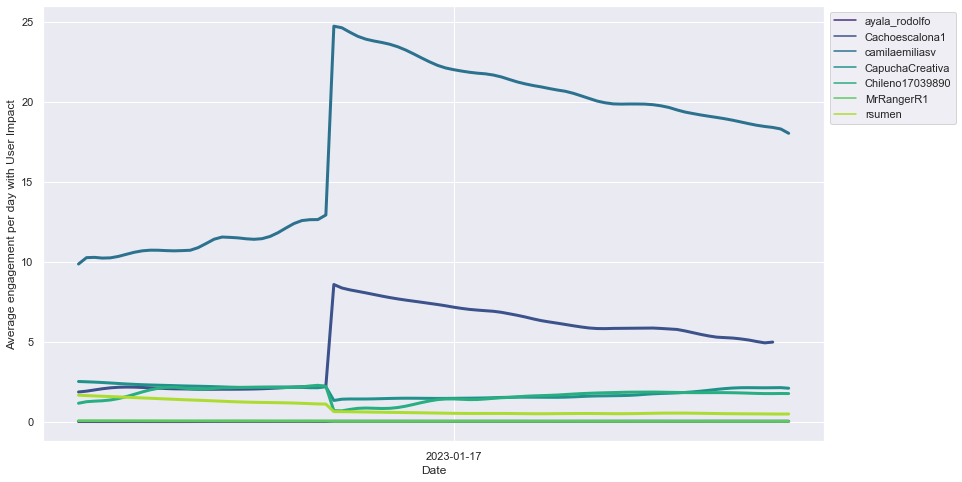

In [60]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=influencers_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('influencers_2023_engagement.pdf')
plt.show()


In [46]:
prensa_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(prensa_avg_engagements_per_day_df["created_at_day"])
prensa_avg_engagements_per_day_df

,created_at_day,tweets_per_day,engagement_rate,average_engagement_per_day,EMA,user,user_impact,zscore,EMA:Degree8,EMA*user_impact
0,2022-12-01,185,3912,5.29,5.290000,adnradiochile,0.501193,-1.920568,5.259738,2.636142
1,2022-12-02,164,7919,12.07,5.424257,adnradiochile,0.501193,-1.842737,5.505420,2.759276
2,2022-12-03,85,8982,26.42,5.840015,adnradiochile,0.501193,-1.601717,5.836262,2.925092
3,2022-12-04,64,6700,26.17,6.242589,adnradiochile,0.501193,-1.368339,6.154191,3.084435
4,2022-12-05,189,13827,18.29,6.481151,adnradiochile,0.501193,-1.230041,6.430748,3.223044
...,...,...,...,...,...,...,...,...,...,...
805,2023-02-24,156,5345,8.57,5.079325,thecliniccl,0.286438,1.312903,5.064130,1.450559
806,2023-02-25,151,2780,4.60,5.069834,thecliniccl,0.286438,1.268610,5.063443,1.450362
807,2023-02-26,105,1352,3.22,5.033203,thecliniccl,0.286438,1.097673,5.035527,1.442366
808,2023-02-27,131,1389,2.65,4.986011,thecliniccl,0.286438,0.877449,4.988543,1.428908


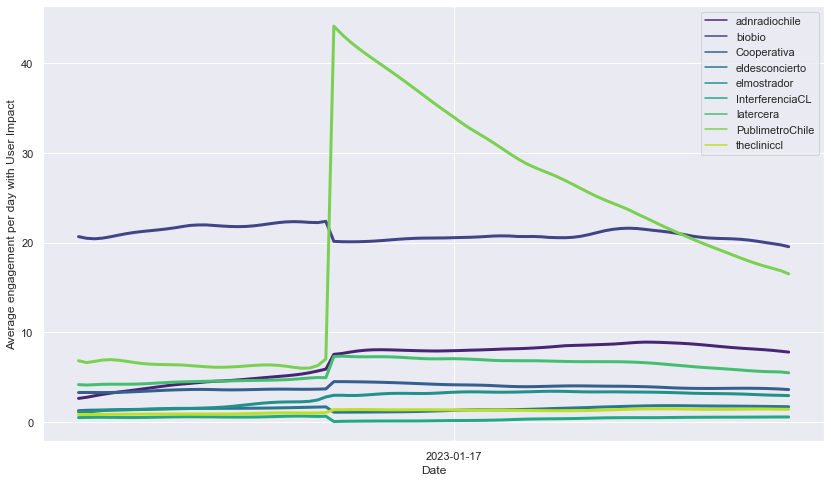

In [61]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=prensa_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('press_2023_engagement.pdf')
plt.show()


In [48]:
television_avg_engagements_per_day_df["created_at_day"] = pd.to_datetime(television_avg_engagements_per_day_df["created_at_day"])
#television_avg_engagements_per_day_df.to_excel("television.xlsx")

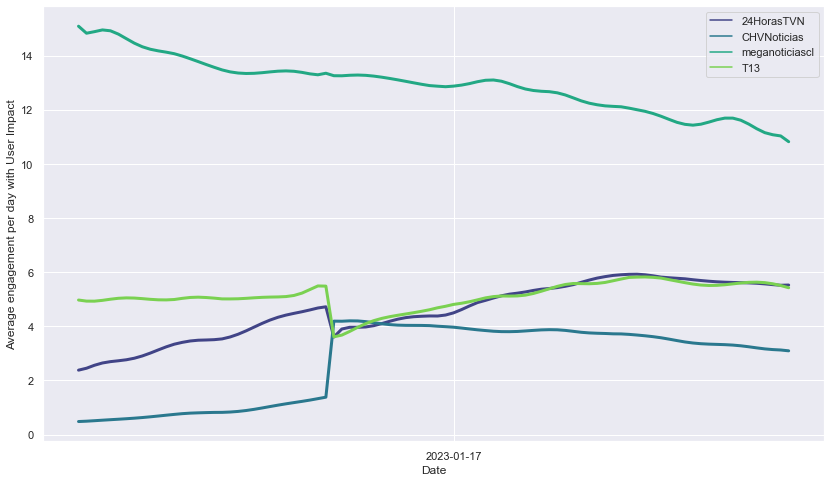

In [62]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=television_avg_engagements_per_day_df, x ='created_at_day', y = 'EMA*user_impact',
                  hue='user', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Average engagement per day with User Impact')
plt.xlabel('Date')
plt.savefig('television_2023_engagement.pdf')
plt.show()
